<a href="https://colab.research.google.com/github/liuy01510/portfolio/blob/master/Python/Optimization/Examples/MIP_Nonlinear_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

In [237]:
try:
    import pulp
except:
    !pip install pulp

import numpy as np
import scipy as sp
import pulp
import matplotlib.pyplot as plt

# Problem Statement
Maximize the following equation:
\begin{equation}
f(x)=20x_1+16x_2-2x_1^2-x_2^2-(x_1+x_2)^2
\end{equation}
Subject to the following constraints:
\begin{equation}
x_1+x_2 \leq 5\\
x_1 \geq 0\\
x_2 \geq 0
\end{equation}

## Simplifying the problem statement
In this case, $x_1+x_2$ can be represented by another variable, $x_3$, where $x_1+x_2=x_3$.
The objective function and the corresponding constraints can then be rewritten as follows:
\begin{equation}
f(x)=20x_1+16x_2-2x_1^2-x_2^2-(x_3)^2
\end{equation}
Subject to the following constraints:
\begin{equation}
x_1+x_2 \leq 5\\
x_1 \geq 0\\
x_2 \geq 0\\
x_3 \geq 0\\
x_1+x_2-x_3=0
\end{equation}

## Separation into individual equations
\begin{equation}
\text{Let } f=f_1+f_2+f_3\\
f_1=-2x_1^2+20x_1\\
f_2=-x_2^2+16x_2\\
f_3=-x_3^2
\end{equation}







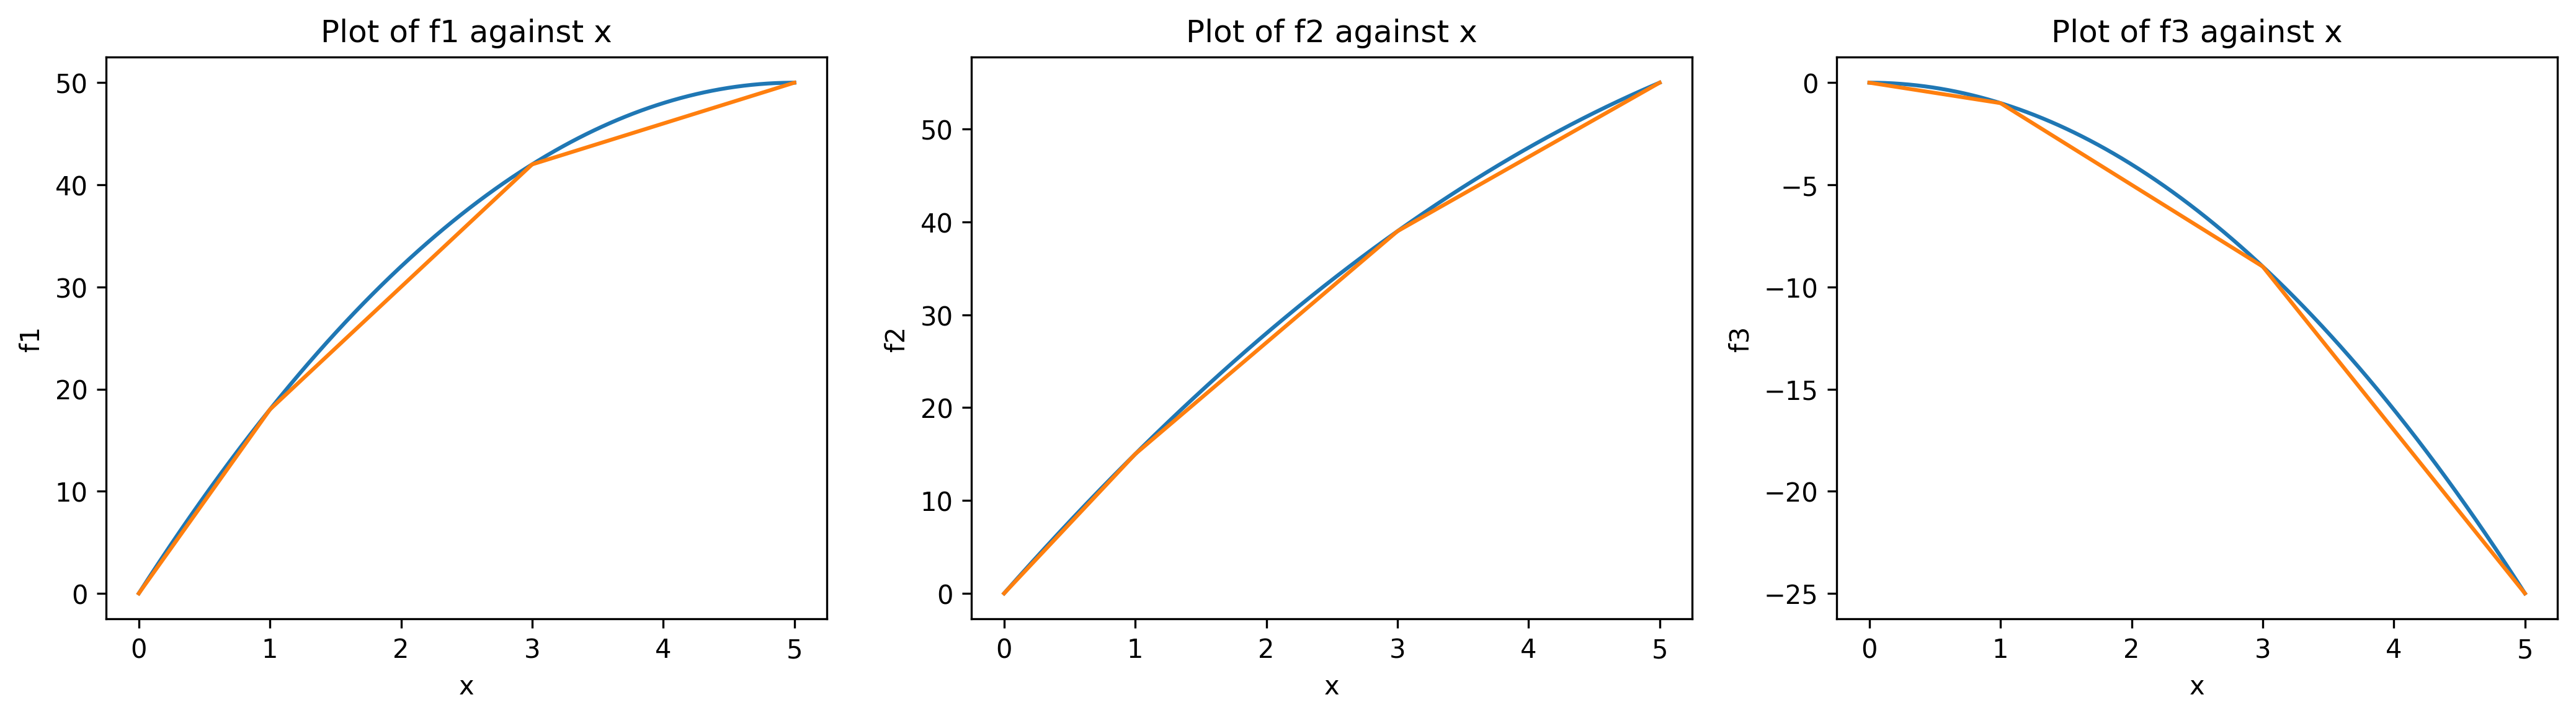

In [238]:
# defining the indivdual functions
f1=lambda x:-2*(x**2)+20*x
f2=lambda x:-1*(x**2)+16*x
f3=lambda x:-1*(x**2)
funcs=[f1,f2,f3]

fig=plt.Figure(figsize=(17,4),dpi=300)


for i,f in enumerate(funcs):
    x=np.linspace(0,5,1000)
    y=[f(a) for a in x]
    ax=fig.add_subplot(1,3,i+1)
    ax.plot(x,y)
    x=[0,1,3,5]
    y=[f(a) for a in x]
    ax.plot(x,y)
    ax.set_title(f'Plot of f{i+1} against x')
    ax.set_ylabel(f'f{i+1}')
    ax.set_xlabel('x')

fig

In [239]:
# getting the gradients of each approximated piecewise linear line
def Gradient(x,y):
    if len(x)!=len(y):
        raise ValueError("The lengths of the x and y iterables must be the same.")
    grad=[]
    for i in range(len(y)-1):
        y1=y[i]
        y2=y[i+1]
        x1=x[i]
        x2=x[i+1]
        gradient=(y2-y1)/(x2-x1)
        grad.append(gradient)
    return grad

x=[0,1,3,5]
g1=Gradient(x,[f1(a) for a in x])
g2=Gradient(x,[f2(a) for a in x])
g3=Gradient(x,[f3(a) for a in x])

# Modelling $f$ using MIP methods

## $f_1$ modelling example

- 3 linear lines are used for approximation.

\begin{align}
\therefore 1 w_{11} \leq &\delta_{11} \leq 1\\
2 w_{12} \leq &\delta_{12} \leq 2 w_{11}\\
0 \leq &\delta_{13} \leq 2 w_{12}
\end{align}
Overall objective function for f1 in terms of $\delta$ :
\begin{equation}
f1=g11 \cdot \delta_{11} + g12 \cdot \delta_{12} 
\cdot g13 \cdot \delta_{13}
\end{equation}

In [240]:
# initializing f1 variables
prob=pulp.LpProblem('MIP_Nonlinear',pulp.LpMaximize) # set a maximization objective.
d11=pulp.LpVariable('d11',0,None,pulp.LpContinuous)
d12=pulp.LpVariable('d12',0,None,pulp.LpContinuous)
d13=pulp.LpVariable('d13',0,None,pulp.LpContinuous)
w11=pulp.LpVariable('w11',0,1,pulp.LpBinary)
w12=pulp.LpVariable('w12',0,1,pulp.LpBinary)

# initializing f1 constraints
prob+=1*w11<=d11<=1
prob+=2*w12<=d12<=2*w11
prob+=0<=d13<=2*w12


# initializing f2 variables
d21=pulp.LpVariable('d21',0,None,pulp.LpContinuous)
d22=pulp.LpVariable('d22',0,None,pulp.LpContinuous)
d23=pulp.LpVariable('d23',0,None,pulp.LpContinuous)
w21=pulp.LpVariable('w21',0,1,pulp.LpBinary)
w22=pulp.LpVariable('w22',0,1,pulp.LpBinary)

# initializing f2 constraints
prob+=1*w21<=d21<=1
prob+=2*w22<=d22<=2*w21
prob+=0<=d23<=2*w22


# initializing f3 variables
d31=pulp.LpVariable('d31',0,None,pulp.LpContinuous)
d32=pulp.LpVariable('d32',0,None,pulp.LpContinuous)
d33=pulp.LpVariable('d33',0,None,pulp.LpContinuous)
w31=pulp.LpVariable('w31',0,1,pulp.LpBinary)
w32=pulp.LpVariable('w32',0,1,pulp.LpBinary)

# initializing f3 constraints
prob+=1*w31<=d31<=1
prob+=2*w32<=d32<=2*w31
prob+=0<=d33<=2*w32

# additional constraints from original equation
prob+=d11+d12+d13+d21+d22+d23-d31-d32-d33==0 # x1+x2=x3

In [241]:
# Adding the objective function
prob+=g1[0]*d11+g1[1]*d12+g1[2]*d13+\
g2[0]*d21+g2[1]*d22+g2[2]*d23+\
g3[0]*d31+g3[1]*d32+g3[2]*d33

In [242]:
# solving the problem and checking the solution status
prob.solve()
print(pulp.LpStatus[prob.status])

Optimal


In [243]:
# Printing out the solution values
for v in prob.variables():
    print(f"{v.name} = {v.varValue}")

d11 = 1.0
d12 = 1.0
d13 = 0.0
d21 = 1.0
d22 = 2.0
d23 = 0.0
d31 = 1.0
d32 = 2.0
d33 = 2.0
w11 = 1.0
w12 = 1.0
w21 = 1.0
w22 = 1.0
w31 = 1.0
w32 = 1.0


# Discussion
Therefore, the solution produced by the solver can be reworked back in terms of the original x values.

\begin{align}
\therefore &x_1=1+1+0=2\\
&x_2=1+2+0=3\\
&x_3=1+2+2=5
\end{align}

The values of $f_1,f_2,f_3$ can also be calculated:
\begin{align}
&f_1=-2(2)^2+20(2)=32\\
&f_2=-(3)^2+16(3)=39\\
&f_3=-(5)^2=-25\\
\therefore &f=f_1+f_2+f_3 = 32+39-25=46
\end{align}

Thus, the final optimal value produced by the approximation is 46. Although the actual optimal value is calculated to be $46 \frac{1}{3}$, the approximation produces a result that is suitably close to the optimal solution.